In [10]:
# 8.5 하이퍼파라미터 선언 및 이미지 변환

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

hyperparams = {
    "batch_size" : 4,
    "learning_rate" : 0.0001,
    "epochs" : 5,
    "transform" : transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224), # 224x224로 중앙 자르기
            transforms.ToTensor(), # HxWxC -> CxHxW
            transforms.Normalize(
                mean=[0.48235, 0.45882, 0.40784],
                std = [1.0/255.0, 1.0/255.0, 1.0/255.0]
            )
        ]
    )
}

# 지정된 경로에 대해서 이미지를 로드하고 이미지에 대해 정의된 변환을 적용
# 이미지폴더 데이터세트는 이미지 데이터를 대상으로 하는 데이터세트로, 폴더 구조가 pet 데이터세트 구조와 같은 형태로 구성되어 있으면 이미지와 레이블을 자동으로 인식
# 자신이 속한 폴더에 따라 레이블이 지정
train_dataset = ImageFolder("../datasets/pet/train", transform=hyperparams["transform"])
test_dataset = ImageFolder("../datasets/pet/test", transform=hyperparams["transform"])

# 배치 크기로 데이터를 셔플링하여 모델이 학습할 수 있도록 준비
train_dataloader = DataLoader(
    train_dataset, batch_size = hyperparams["batch_size"], shuffle=True, drop_last=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=hyperparams["batch_size"], shuffle=True, drop_last=True
)

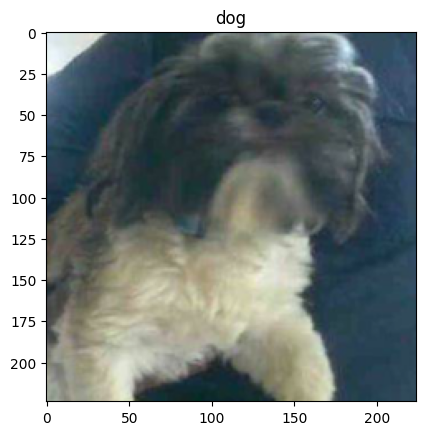

In [11]:
# 8.6 데이터 시각화

import numpy as np
from matplotlib import pyplot as plt

mean = [0.48235, 0.45882, 0.40784]
std = [1.0/255.0, 1.0/255.0, 1.0/255.0]

images,labels = next(iter(train_dataloader))
for image,label in zip(images, labels):
    image = image.numpy().transpose((1,2,0)) # CxHxW -> HxWxC
    image = ((std*image + mean) * 255).astype(np.uint8)

    plt.imshow(image)
    plt.title(train_dataset.classes[int(label)])
    plt.show()
    break

In [12]:
# 8.7 VGG-16 모델 불러오기 및 계층 구조 출력

from torchvision import models

model = models.vgg16(weights = "VGG16_Weights.IMAGENET1K_V1")
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# 8.8 VGG-16 미세 조정
# 현재 모델은 1000개의 클래스가 아닌, 2개의 클래스를 대상으로 분류하므로 마지막 계층의 출력 특징을 2개로 변경해야한다.

from torch import nn

model.classifier[6] = nn.Linear(4096, len(train_dataset.classes))
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
# 8.9 VGG-16 모델 학습

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

device = "cuda" if torch.cuda.is_available() else "mps"
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=hyperparams["learning_rate"])

for epoch in range(hyperparams["epochs"]):
    cost = 0.0

    for images, classes in train_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        loss = criterion(output, classes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss

    cost = cost/len(train_dataloader)
    print(f"Epoch : {epoch+1:4d}, Cost : {cost:.3f}")

with torch.no_grad():
    model.eval()

    accuracy = 0.0
    for images, classes in test_dataloader:
        images = images.to(device)
        classes = classes.to(device)

        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        outputs_classes = torch.argmax(probs, dim=1)

        accuracy += int(torch.eq(classes, outputs_classes).sum())
    
    print(f"acc01 : {accuracy / (len(test_dataloader) * hyperparams['batch_size']) * 100:.2f}%")

torch.save(model.state_dict(), "../models/VGG16.pt")
print("Saved the model weights")

Epoch :    1, Cost : 0.081
Epoch :    2, Cost : 0.054
Epoch :    3, Cost : 0.038
Epoch :    4, Cost : 0.026
Epoch :    5, Cost : 0.020
acc01 : 97.67%
Saved the model weights
